# Standard pipeline for scooby: analyzing 10K Multiome PBMC dataset from 10X genomics

## Introduction
In this tutorial we will extract the training data (profiles) for single-cell ATAC-seq data and RNA-seq data from Peripheral blood mononuclear cells (PBMCs).

## Import library and environment setup

In [ ]:
import snapatac2_scooby as sp
import scanpy as sc
import pandas as pd
import scipy.sparse

sp.__version__

'1.0.0'

We next need to download the bam files for RNA-seq, the fragment files for ATAC-seq and the count matrix.

In [9]:
# ! curl -O https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_gex_possorted_bam.bam
# ! curl -O https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_gex_possorted_bam.bam.bai
# ! curl -O https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz
# ! curl -O https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz.tbi
# ! curl -O https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5

## Read count matrix

In [10]:
adata_count = sc.read_10x_h5("pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5", gex_only=False)

/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Read RNA Sequencing Data

We need to load and process our RNA sequencing bam files. This involves converting the raw BAM files into fragment files that SnapATAC can then read into the anndata format.

### Generating Fragment Files with SnapATAC

We have adapted snapATACs `sp.pp.make_fragment_file` function to also handle RNA-seq bam files that differ from ATAC-seq bam files in that they can contain split reads.

Here's a breakdown of the essential parameters and why they matter, specifically for RNA-seq data:

**1. Specifying Barcode and UMI Tags:**

- `barcode_tag`: This tells SnapATAC where to find the cell barcode information within each sequencing read. For data processed with 10x Genomics Cell Ranger, the default tag is `"CB"`. 
- `umi_tag`: This identifies the tag containing the Unique Molecular Identifier (UMI). SnapAtac automatically tries to remove PCR duplicates by filtering out reads that have exactly the same UMI and start and end value. For data processed with 10x Genomics Cell Ranger, the default tag is `"UB"`.

**2. Handling Read Strandedness:**

- `stranded`: Unlike ATAC-seq data, that usually are processed unstranded, RNA transcripts have a defined direction. Set `stranded=True` to create separate coverage tracks for reads mapping to the positive and negative strands of the genome that we will model as separate tracks.

**3. Addressing ATAC-Specific Parameters:**

- `is_paired`: Unlike most ATAC-seq reads, RNA-seq reads are not paired, so this argument needs to be set to `False`.
- `shift_left` and `shift_right`: These parameters are designed to correct for fragment shifts inherent to ATAC-seq data. For RNA-seq analysis, **it is essential to set both of these parameters to 0**.

**4. Leveraging High-Quality Reads (Cell Ranger > 3.0):**

- `xf_filter`: If your BAM files were aligned with Cell Ranger versions 3.0 or later, you'll find a helpful flag called "xf." This flag marks reads deemed to be of high quality by Cell Ranger's analysis pipeline. Setting `xf_filter=True` ensures that only these high-confidence reads contribute to your coverage tracks. This is **recommended** .  


In [7]:
%%time
sp.pp.make_fragment_file(
    bam_file="pbmc_granulocyte_sorted_3k_gex_possorted_bam.bam", 
    output_file="pbmc_granulocyte_sorted_3k_gex.fragments.bed.gz",
    barcode_tag="CB", 
    umi_tag="UB",
    umi_regex=None, 
    stranded=True, 
    is_paired=False, 
    shift_left=0, 
    shift_right=0, 
    xf_filter=True
)

CPU times: user 6min 59s, sys: 9.64 s, total: 7min 9s
Wall time: 7min 16s


{'frac_duplicates': 0.0,
 'frac_unmapped': 0.04059085115926564,
 'sequenced_reads': 164560538.0,
 'frac_valid_barcode': 0.9572655444283975,
 'frac_fragment_in_nucleosome_free_region': 0.9148212455488332,
 'frac_q30_bases_read2': nan,
 'sequenced_read_pairs': 0.0,
 'frac_q30_bases_read1': 0.8802099624070667,
 'frac_confidently_mapped': 0.9002277265282154,
 'frac_fragment_flanking_single_nucleosome': 0.0,
 'frac_nonnuclear': 0.10006990254249169}

The code creates two fragment files `pbmc_granulocyte_sorted_3k_gex.fragments.bed.minus.gz` and `pbmc_granulocyte_sorted_3k_gex.fragments.bed.plus.gz`, one for each strand.

### Read fragment files into AnnData format

We next want to read the fragment files into a AnnData object that stores the coverage information for each cell. Here we need to specify the genome that was used to align the data and the barcodes of cells that we would like to read. By default, we just use the barcodes of our filtered count matrix `adata_count`.

In [58]:
%%time
rna_coverage_plus = sp.pp.import_fragments(
                    "pbmc_granulocyte_sorted_3k_gex.fragments.bed.plus.gz", 
                    chrom_sizes=sp.genome.hg38, 
                    min_num_fragments=0, 
                    n_jobs=-1,
                    whitelist=adata_count.obs_names
                )
rna_coverage_minus = sp.pp.import_fragments(
                    "pbmc_granulocyte_sorted_3k_gex.fragments.bed.minus.gz", 
                    chrom_sizes=sp.genome.hg38, 
                    min_num_fragments=0, 
                    n_jobs=-1,
                    whitelist=adata_count.obs_names
                )

CPU times: user 10.4 s, sys: 387 ms, total: 10.8 s
Wall time: 5.67 s


In [59]:
assert (rna_coverage_plus.obs_names == adata_count.obs_names).all()

We now have the RNA coverage of both strands for each cell in the convenient adata format. The coverage is stored in `adata.obsm['fragment_single']`.

## Read ATAC Sequencing data

For ATAC data, we can usually directly start with the fragment files and read them into adata format. If you are directly starting with the fragment file and not the bam file, you want to set `sorted_by_barcode=False`. 

In [61]:
%%time
atac_coverage = sp.pp.import_fragments(
                "pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz", 
                chrom_sizes=sp.genome.hg38, 
                min_num_fragments=0, 
                n_jobs=-1,
                whitelist=adata_count.obs_names,
                sorted_by_barcode=False
            )

CPU times: user 1min 21s, sys: 2.23 s, total: 1min 23s
Wall time: 44.2 s


We next have to convert the fragments to insertion sites:

In [62]:
%%time
sp.pp.fragments_to_insertions(atac_coverage)

CPU times: user 1.09 s, sys: 85.1 ms, total: 1.18 s
Wall time: 1.18 s


## Save snapatac anndatas

Add empty X to anndata. This is not necessary but is needed for concatinating on disk.

In [ ]:
rna_coverage_plus.X = scipy.sparse.csr_matrix((rna_coverage_plus.obsm['fragment_single'].shape[0], 0))
rna_coverage_minus.X = scipy.sparse.csr_matrix((rna_coverage_minus.obsm['fragment_single'].shape[0], 0))
atac_coverage.X = scipy.sparse.csr_matrix((atac_coverage.obsm['fragment_paired'].shape[0], 0))

In [63]:
rna_coverage_plus.write("snapatac_rna_plus.h5ad")
rna_coverage_minus.write("snapatac_rna_minus.h5ad")
atac_coverage.write("snapatac_atac.h5ad")

We have now created three adata coverage files for RNA positive strand coverage, RNA negative strand coverage and ATAC insertions that we can use for training scooby!

## Load multiple samples into snapatac

If you have multiple samples in your dataset, you should process them separately and then concatenate the generated anndata objects. See [here](https://github.com/gagneurlab/scooby_reproducibility/blob/main/notebooks/data_preparation/load_neurips_into_snapatac.ipynb) for an example. If your anndata objects are large, you can make use of the `anndata.experimental.concat_on_disk` functionality. After concatenation, you'll have to re-add the chromsizes. Here is some code to do that once you have generated the adatas per sample as above:

```
for strand in ['plus', 'minus']:
    print(strand)
    adatas = [
        os.path.join(data_path, f'snapatac_{sample}_{strand}.h5ad') 
     for sample in samples
    ]

    # needs empty .X
    anndata.experimental.concat_on_disk(
        in_files=adatas, 
        out_file=os.path.join(data_path, f'snapatac_merged_{strand}.h5ad'),
        uns_merge='unique'
    )

    # uns merge is not working, add that manually
    adata_cov = sc.read_h5ad(os.path.join(data_path, f'snapatac_merged_{strand}.h5ad'))

    test = sc.read(adatas[0])

    adata_cov.uns = test.uns.copy()
    adata_cov.write(os.path.join(data_path, f'snapatac_merged_{strand}.h5ad'))
```

## Create embedding

In [ ]:
import scvi
from lightning.pytorch.loggers import WandbLogger
import wandb

We next need to create an embedding of our data that we can use for scooby. Since we have multiome data, we will use `POISSONMULIVI` from `scvi-tools` but you could also run PCA or LSI or another dimensionality reduction technique of your choice.

### Prepare the data for training

We will use PoissonMultiVI which models the scRNA-seq data using a negative binomial distribution and the scATAC-seq data using the Poisson distribution. For that we first have to convert the ATAC read counts to fragment counts. For a detailed explanation see the tutorial [here](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/atac/PoissonVI.html).

In [12]:
adata_rna = adata_count[:, adata_count.var.feature_types=='Gene Expression']

In [13]:
adata_atac = adata_count[:, adata_count.var.feature_types=='Peaks']

In [16]:
(adata_atac.X.data == 1).sum()/(adata_atac.X.data == 2).sum() # simple check to see if we are dealing with reads or counts (see tutorial on scvi)

0.16570730752899918

In [17]:
scvi.data.reads_to_fragments(adata_atac, read_layer=None)

/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/scvi/data/_preprocessing.py:467: ImplicitModificationWarning: Setting element `.layers['fragments']` of view, initializing view as actual.
  adata.layers[fragment_layer] = (


In [18]:
adata_atac.X = adata_atac.layers['fragments'].copy()

In [21]:
adata_train = sc.concat([adata_rna, adata_atac], axis=1)

/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [23]:
adata_train.obs = adata_train.obs.join(adata_count.obs)

In [24]:
print(adata_train.shape)
sc.pp.filter_genes(adata_train, min_cells=int(adata_train.shape[0] * 0.01))
print(adata_train.shape)

(2711, 134920)
(2711, 98244)


/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


### Train the model

In [29]:
# you can log the loss using wandb
wandb_logger = WandbLogger(project="scooby_example", entity='lauradm')

In [30]:
scvi.external.POISSONMULTIVI.setup_anndata(adata_train, batch_key=None)

2024-11-21 18:18:43 - INFO - Unable to initialize backend 'cuda': 
2024-11-21 18:18:43 - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-11-21 18:18:44 - INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-11-21 18:18:44 - WARNING - An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [31]:
model = scvi.external.POISSONMULTIVI(
    adata_train,
    n_genes=(adata_train.var["feature_types"] == 'Gene Expression').sum(),
    n_regions=(adata_train.var["feature_types"] == 'Peaks').sum(),
    fully_paired=True, 
)
model.view_anndata_setup()

/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Anndata setup with scvi-tools version 1.1.3.

Setup via `POISSONMULTIVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'size_factor_key_expr': None,
│   'size_factor_key_acc': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None,
│   'protein_expression_obsm_key': None,
│   'protein_names_uns_key': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 2711  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 98244 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

In [32]:
model.train(accelerator='gpu', adversarial_mixing=False, logger=wandb_logger)

/scratch/tmp/martensl/ipykernel_861956/3717432196.py:1: DeprecationWarning: `save_best` is deprecated in v1.2 and will be removed in v1.3. Please use `enable_checkpointing` instead. See https://github.com/scverse/scvi-tools/issues/2568 for more details.
  model.train(accelerator='gpu', adversarial_mixing=False, logger=wandb_logger)
INFO: GPU available: True (cuda), used: True
2024-11-21 18:19:15 - INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2024-11-21 18:19:15 - INFO - TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
2024-11-21 18:19:15 - INFO - IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
2024-11-21 18:19:15 - INFO - HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For m

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2024-11-21 18:19:26 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
2024-11-21 18:19:27 - INFO - SLURM auto-requeueing enabled. Setting signal handlers.
/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/opt/modules/i12g/anaconda/envs/scooby_reproducibility/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 184/500:  37%|███▋      | 184/500 [03:57<06:48,  1.29s/it, v_num=ddse, train_loss_step=3.12e+4, train_loss_epoch=2.64e+4]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 28870.994. Signaling Trainer to stop.


### Extract the embedding and compute clustering

We can now get the embedding from trained model.

In [34]:
X_emb = model.get_latent_representation()

We can quickly check how our embedding looks like in a UMAP representation. Since we don't have a cell type annotation for this dataset, we will also compute a clustering.

In [36]:
adata_count.obsm['X_poisson_multivi'] = X_emb

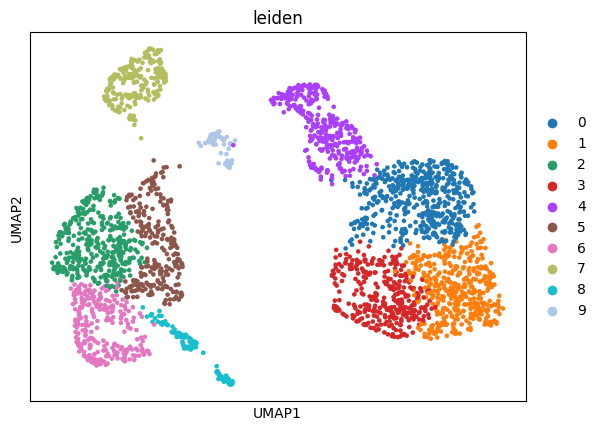

In [42]:
sc.pp.neighbors(adata_count, use_rep='X_poisson_multivi')
sc.tl.umap(adata_count)
sc.tl.leiden(adata_count, resolution=.4, random_state=0)
sc.pl.umap(adata_count, color='leiden')

### Save embedding

In [47]:
embedding = pd.DataFrame({
    'embedding':list(adata_count.obsm['X_poisson_multivi']), 
    'obs_names': adata_count.obs.index
})

embedding.to_parquet("embedding.pq")

### Save empty neighbors

scooby has the option to train with "metacells" in which the profiles are aggregated over the nearest neighbors but in practise we did not observe any performance improvement which is why we can train scooby truly at the single cell level. We will therefore just write out an empty neighborhood file.

In [50]:
empty_csr = scipy.sparse.csr_matrix((adata_count.shape[0], adata_count.shape[0])) 
scipy.sparse.save_npz("no_neighbors.npz", empty_csr)

## Create pseudobulk files for evaluation

We can later evaluate our model using the [Evaluation notebook](Evaluate_Model.ipynb). This is fastest if we write out our cell types as pseudobulk bigwigs which can be done using SnapATAC2. In our case, we will use the clustering as our cell types but in a real world example you would probably use your annotated cell types.

In [55]:
rna_coverage_plus.obs = adata_count.obs
rna_coverage_minus.obs = adata_count.obs

In [56]:
#plus strand
sp.ex.export_coverage(
    rna_coverage_plus, 
    groupby='leiden', 
    bin_size=1, 
    out_dir="pseudobulks", 
    normalization=None,
    n_jobs=-1,
    max_frag_length=None,
    suffix='.bw',
    prefix="plus."
)

#minus strand
sp.ex.export_coverage(
    rna_coverage_minus, 
    groupby='leiden', 
    bin_size=1, 
    out_dir="pseudobulks", 
    normalization=None,
    n_jobs=-1,
    max_frag_length=None,
    suffix='.bw',
    prefix="minus."
)

2024-11-21 18:48:38 - INFO - Exporting fragments...
2024-11-21 18:48:48 - INFO - Creating coverage files...
2024-11-21 18:49:01 - INFO - Exporting fragments...
2024-11-21 18:49:07 - INFO - Creating coverage files...


{'6': 'pseudobulks/minus.6.bw',
 '1': 'pseudobulks/minus.1.bw',
 '8': 'pseudobulks/minus.8.bw',
 '4': 'pseudobulks/minus.4.bw',
 '3': 'pseudobulks/minus.3.bw',
 '5': 'pseudobulks/minus.5.bw',
 '9': 'pseudobulks/minus.9.bw',
 '2': 'pseudobulks/minus.2.bw',
 '7': 'pseudobulks/minus.7.bw',
 '0': 'pseudobulks/minus.0.bw'}

We have now prepared all the data that is needed to train and evaluate a scooby model.